# Image Processing Lab03
---

## Setup

In [ ]:
!apt update && apt install -y ffmpeg libsm6 libxext6
!pip install opencv-python
!pip install scikit-image

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:2 http://deb.debian.org/debian buster InRelease [122 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [314 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,906 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8,792 B]
Fetched 8,468 kB in 3s (3,343 kB/s)



5 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil56

## Import

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from skimage.exposure import cumulative_distribution

## 3.1 Image Pixel Adjustment (Gamma)

In [ ]:
img1 = cv.imread("pic2.jpg")

In [ ]:
a = 1.0
b = 0.0


gamma_arr_1 = np.linspace(0.1, 3, 100) # จากสว่างไปมืด
gamma_arr_2 = np.linspace(3, 0.1, 100) # จากมืดไปสว่าง
gamma_arr = np.concatenate((gamma_arr_1, gamma_arr_2))

In [ ]:
def write(filename, img1, fps):
    fourcc = cv.VideoWriter_fourcc('M', 'P', '4', 'V')
    out = cv.VideoWriter(filename, fourcc, fps, (1280, 720))

    for gamma in gamma_arr:
        img_gamma = ((a*((img1 / 255) ** gamma) + b) * 255).astype(np.uint8)
        out.write(img_gamma)

    out.release()

write("test.mp4", img1, 20)

## 3.2 Image Histogram Equalization

In [ ]:
img1 = cv.imread("pic2.jpg")
height, width, channels = img1.shape
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

In [ ]:
equal_hist_img = np.zeros(shape=(height, width, channels), dtype=np.uint8)
equal_hist_img[:, :, 0] = cv.equalizeHist(img1[:, : , 0])
equal_hist_img[:, :, 1] = cv.equalizeHist(img1[:, :, 1])
equal_hist_img[:, :, 2] = cv.equalizeHist(img1[:, :, 2])

Text(0.5, 1.0, 'Hist Equalized Image')

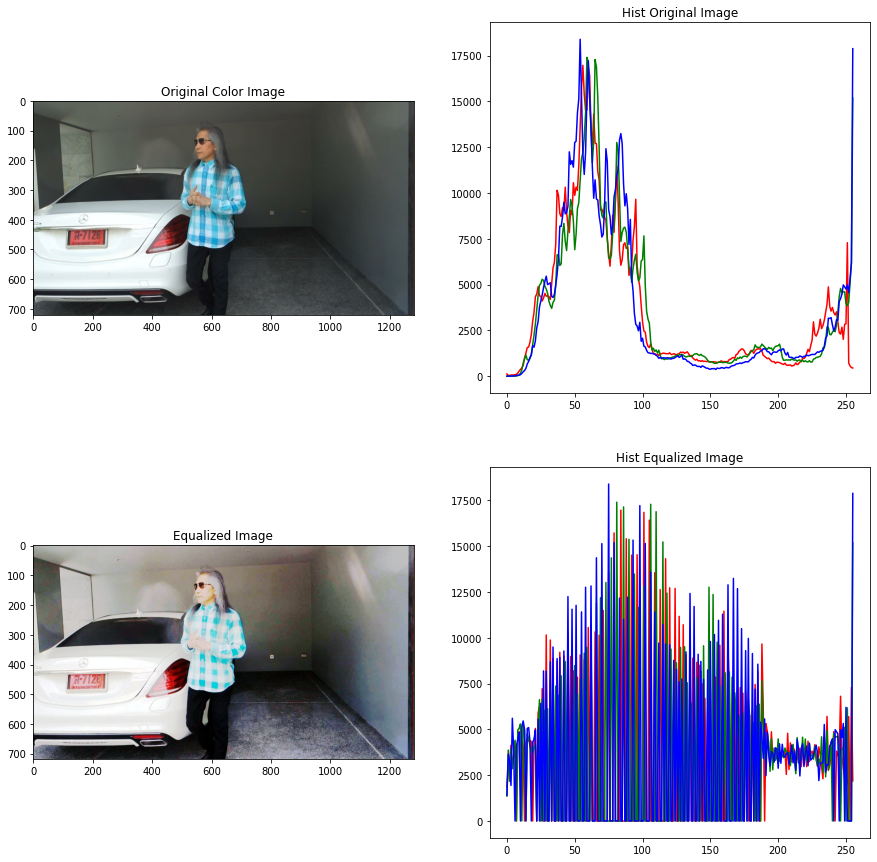

In [ ]:
def plot_img_histogram(img, ax):
    chans = cv.split(img)
    colors = ("r", "g", "b")
    for chan, color in zip(chans, colors):
        histr = cv.calcHist([chan], [0], None, [256], [0, 256])
        ax.plot(histr, color)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0, 0].imshow(img1)
ax[0, 0].set_title("Original Color Image")
plot_img_histogram(img1, ax[0, 1])
ax[0, 1].set_title("Hist Original Image")

ax[1, 0].imshow(equal_hist_img)
ax[1, 0].set_title("Equalized Image")
plot_img_histogram(equal_hist_img, ax[1, 1])
ax[1, 1].set_title("Hist Equalized Image")

## 3.3 Image Histogram Matching

In [ ]:
def cdf(im):
    c, b = cumulative_distribution(im)
    for i in range(b[0]):
        c = np.insert(c, 0, 0)
    for i in range(b[-1] + 1, 256):
        c = np.append(c, 1)
    return c

def hist_matching(c, c_t, im):
    b = np.interp(c, c_t, np.arange(256))
    pix_repl =  {i: b[i] for i in range(256)}
    mp = np.arange(0, 256)
    for (k, v) in pix_repl.items():
        mp[k] = v
    s = im.shape
    im = np.reshape(mp[im.ravel()], im.shape)
    im = np.reshape(im, s)
    return im

In [ ]:
img1 = cv.imread("pic2.jpg")
height, width, channels = img1.shape
img2 = cv.imread("fire.jpg")

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

In [ ]:
cdf_im1_r = cdf(img1[:, :, 0])
cdf_im1_g = cdf(img1[:, :, 1])
cdf_im1_b = cdf(img1[:, :, 2])

cdf_im2_r = cdf(img2[:, :, 0])
cdf_im2_g = cdf(img2[:, :, 1])
cdf_im2_b = cdf(img2[:, :, 2])

im_result = np.zeros(shape=(height, width, channels), dtype=np.uint8)

im_result[:, :, 0] = hist_matching(cdf_im1_r, cdf_im2_r, img1[:, :, 0])
im_result[:, :, 1] = hist_matching(cdf_im1_g, cdf_im2_g, img1[:, :, 1])
im_result[:, :, 2] = hist_matching(cdf_im1_b, cdf_im2_b, img1[:, :, 2])

Text(0.5, 1.0, 'Hist Matching Image')

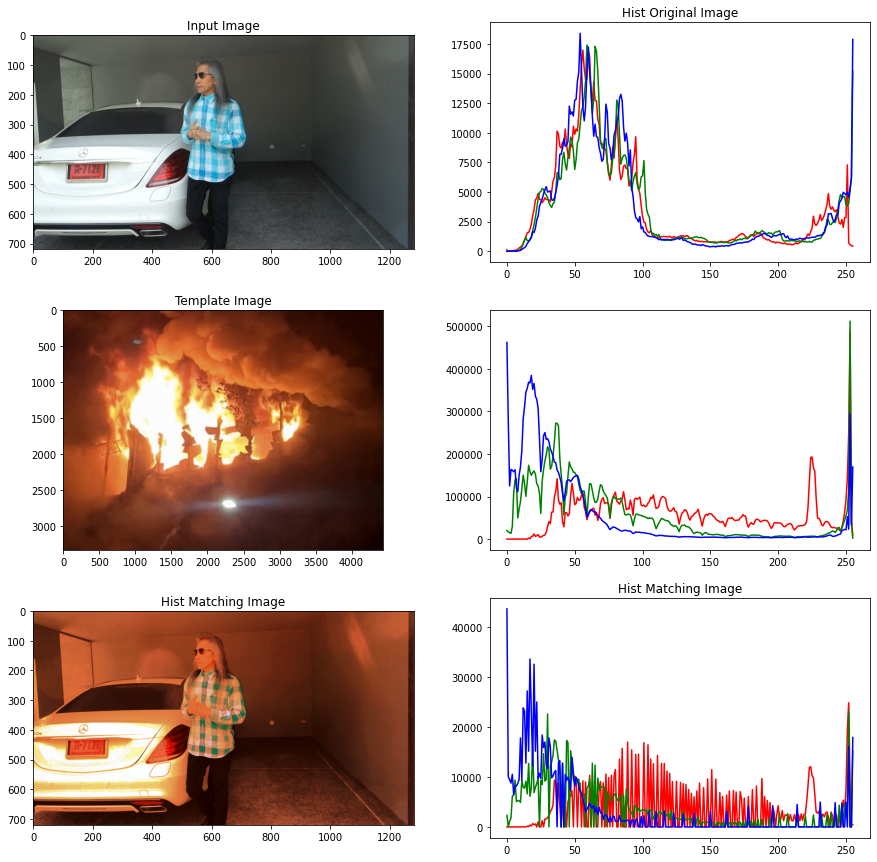

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

ax[0, 0].imshow(img1)
ax[0, 0].set_title("Input Image")
plot_img_histogram(img1, ax[0, 1])
ax[0, 1].set_title("Hist Original Image")


ax[1, 0].imshow(img2)
ax[1, 0].set_title("Template Image")
plot_img_histogram(img2, ax[1, 1])

ax[2, 0].imshow(im_result)
ax[2, 0].set_title("Hist Matching Image")
plot_img_histogram(im_result, ax[2, 1])
ax[2, 1].set_title("Hist Matching Image")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aabfef68-4158-4c7b-af68-4ec6f44c7bd7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>